# A Monte Carlo program for the Newman-Moore triangular lattice Ising model

In [1]:
using DelimitedFiles
using Random; Random.seed!(0);
rng = MersenneTwister(1234);

const EqSteps = 100
const NumSteps = 1000 #Monte Carlo production steps

#k = 2
#L = 2^k
L = 64
N = L*L
Spin = fill(1,N);

In [2]:
#This is the data structure that relates up-triangles to spin indices
function make_up_triangle(L, N)
    UpTriangle = zeros(Int,N,3)
    for i = 1:N
        UpTriangle[i,1] = i
        UpTriangle[i,2] = i+1    
        UpTriangle[i,3] = i+L
        #fix PBCs
        if mod(i,L) == 0
            UpTriangle[i,2] = i + 1 - L
        end
        if (i+L)> N
            UpTriangle[i,3] = i + L - N
        end
    end
    return UpTriangle
end
UpTriangle = make_up_triangle(L, N);

In [3]:
#This is the inverse data structure that relates a spin index to its 3 up-triangles
function make_associated_tri(L, N)
    AssociatedTri = zeros(Int,N,3)
    for i = 1:N
        AssociatedTri[i,1] = i
        AssociatedTri[i,2] = i-1
        AssociatedTri[i,3] = i-L
        if mod(i-1+L,L) == 0
            AssociatedTri[i,2] = i - 1 + L
        end
        if i<(L+1) 
            AssociatedTri[i,3] = i + N - L
        end
    end
    return AssociatedTri
end
AssociatedTri = make_associated_tri(L, N);

In [4]:
#here is the brute force calculation of the energy
function Energy_Total(Energy,Spin)
    Energy = 0
    for i = 1:N
        Spin1 = Spin[UpTriangle[i,1]]
        Spin2 = Spin[UpTriangle[i,2]]
        Spin3 = Spin[UpTriangle[i,3]]
        Energy += Spin1 * Spin2 * Spin3  #J = 1
        end # limit all arithmetic to integers for as long as we can
    return Energy / 2
end #Energy_Total

Energy_Total (generic function with 1 method)

In [5]:
#here is the energy DIFFERENCE calculated from the local triangular plaquettes
function Energy_Diff(Spin,spin_index)
    
    Tri1 = AssociatedTri[spin_index,1]
    Tri2 = AssociatedTri[spin_index,2]
    Tri3 = AssociatedTri[spin_index,3]

    plaquette_factor = 0
    plaquette_factor -= Spin[UpTriangle[Tri1,2]] * Spin[UpTriangle[Tri1,3]]
    plaquette_factor -= Spin[UpTriangle[Tri2,1]] * Spin[UpTriangle[Tri2,3]]
    plaquette_factor -= Spin[UpTriangle[Tri3,1]] * Spin[UpTriangle[Tri3,2]]
    
    return Spin[spin_index] * plaquette_factor
end

# Energy_Diff can only take 4 values: -3, -1, 1, 3
# BUT, the non-positive values always result in acceptance
# so we only need to cache the value of exp(-dE / T) for 2 values of dE
# we'll store these values in a tuple of length 3, and get the
# acceptance prob by indexing with dE

Energy_Diff (generic function with 1 method)

In [6]:
function MetropolisAccept(DeltaE::Int, acceptance_ratios::NTuple{3, Float64})::Bool
    if DeltaE <= 0
        return true
    else
        rnum = rand(rng)  #random number for Metropolis
        if (acceptance_ratios[DeltaE] > rnum)
            return true
        end
    end 
    return false
end

MetropolisAccept (generic function with 1 method)

In [7]:
Tarr = zeros(Float64,0)  
EMC = zeros(Float64,0)  
SpecHeat = zeros(Float64,0)  
Eexact = zeros(Float64,0)
Acceptance = zeros(Float64,0) 

const gamma = 0.05
const stoptime = 18
for time = 0:stoptime
#for T = 10:-0.1:0.1  #count down  
    
    print(time," ")
    T = exp(-gamma*time)
    beta = 1.0/T
    
    acceptance_ratios = (exp(-beta*1), exp(-beta*2), exp(-beta*3))

    #initialize the energy
    Energy = 0
    Energy=Energy_Total(Energy,Spin)
    #println(Energy)

    for step = 1:EqSteps
        for i = 1:N  #multiple single spin flips
            spin_i = rand(1:N)
            DeltaE = Energy_Diff(Spin,spin_i)
            if MetropolisAccept(DeltaE, acceptance_ratios)
                Energy += DeltaE
                Spin[spin_i] *= -1
            end 
        end #i
    end #Equilibration
    
    E_avg = 0
    E2 = 0
    A_rate = 0
    for step = 1:NumSteps
        Accept = 0
        for i = 1:N  #multiple single spin flips
            spin_i = rand(1:N)
            DeltaE = Energy_Diff(Spin,spin_i)
            if MetropolisAccept(DeltaE, acceptance_ratios)
                Energy += DeltaE
                Spin[spin_i] *= -1
                Accept += 1
            end 
        end #i
        E_avg += Energy
        E2 += Energy*Energy
        A_rate += Accept/N
    end #Monte Carlo production step

    E_exact = 1/(1+exp(beta))
    Cv = E2/NumSteps - (E_exact/NumSteps)^2
    println(T," ",E_avg/NumSteps/N," ",E_exact-0.5," ",Cv/N/T/T," ",A_rate/NumSteps)
     
    push!(Tarr,T)
    push!(EMC,E_avg/NumSteps/N)
    push!(SpecHeat,Cv/(T*T*N))
    push!(Eexact,E_exact-0.5)
    push!(Acceptance,A_rate/NumSteps)
    
    #Let's write configuration files for data
    if time == stoptime
        Tstring = first(string(T),8)
        filename = string("T",Tstring,".dat")
        
        for step = 1:2 #configuration data files
            for i = 1:20*N  #multiple single spin flips
                spin_i = rand(1:N)
                DeltaE = Energy_Diff(Spin,spin_i)
                if MetropolisAccept(DeltaE, acceptance_ratios)
                    Energy += DeltaE
                    Spin[spin_i] *= -1
                    end 
                end #i

            open(filename, "a") do io
                writedlm(io, Spin' , " ")
            end
        end #step
    end #stoptime

end #T


0 1.0 -0.231166748046875 -0.2310585786300049 219.07166528318547 0.35634716796875
1 0.951229424500714 -0.2413974609375 -0.2410189098634476 264.0099759567621 0.3321435546875
2 0.9048374180359595 -0.250558837890625 -0.25122772556372186 314.30797161029136 0.310299560546875
3 0.8607079764250578 -0.261896240234375 -0.2616658465277084 379.45935613003525 0.286473388671875
4 0.8187307530779818 -0.272180908203125 -0.27231031459107935 452.93766074744633 0.2638271484375
5 0.7788007830714049 -0.282749267578125 -0.2831342122881081 540.1793872425837 0.242111572265625
6 0.7408182206817178 -0.294144287109375 -0.29410654400704594 646.0435248436795 0.21926904296875
7 0.7046880897187134 -0.305872802734375 -0.30519219582497953 771.9986081003726 0.196956298828125
8 0.6703200460356393 -0.316346435546875 -0.3163519917645896 912.5791277142711 0.177334228515625
9 0.6376281516217732 -0.3272763671875 -0.3275428638318262 1079.4169261013617 0.158004150390625
10 0.6065306597126334 -0.33856591796875 -0.33871815160443

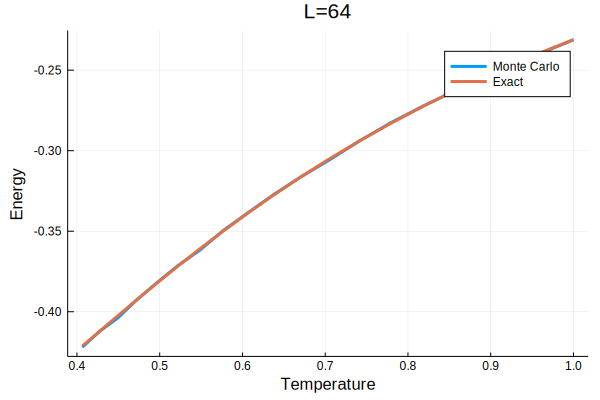

In [8]:
using Plots

plot(Tarr, [EMC, Eexact], title = "L=64", label = ["Monte Carlo" "Exact"], lw = 3 )
xlabel!("Temperature")
ylabel!("Energy")

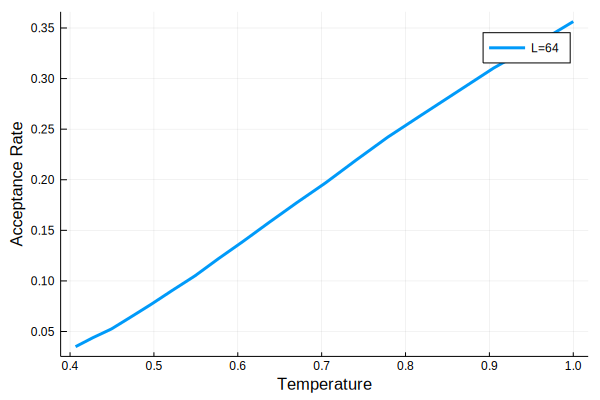

In [9]:
plot(Tarr, Acceptance, label = "L=64", lw = 3 )
xlabel!("Temperature")
ylabel!("Acceptance Rate")